In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
from motion.detect_human import BBoxDataset

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [3]:
SZ = 500

In [4]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb
def visualize(sample):
    
    return plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(255, 0, 0),3)
    return img
    

(1150, 4)
(500, 500, 3)


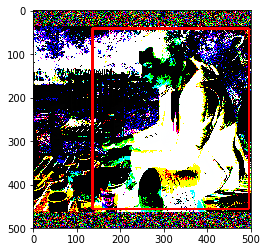

In [5]:
bbdata = BBoxDataset("coco/val2017_one_human.csv", size = SZ, type = "val")
sample = bbdata[4]
plt.imshow(visualize(sample))

(1150, 4)
(500, 500, 3)


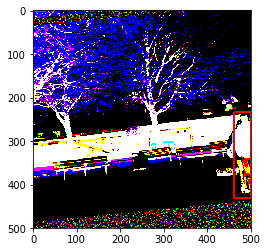

In [6]:
bbdata = BBoxDataset("coco/val2017_one_human.csv", size = SZ, type = "train")
sample = bbdata[990]
plt.imshow(visualize(sample))

In [7]:
bbdata.debug_stats

{'x': {'in': (598, 39, 640, 500), 'out': ([0, 500, 138, 638], [460, 499])},
 'y': {'in': (235, 186, 427, 500), 'out': ([9, 436, 0, 427], [244, 430])},
 'norm_bbox': {'in': array([461.043509, 233.569019, 500.      , 431.757937]),
  'out': array([0.922087, 0.467138, 1.      , 0.863516])}}

In [102]:
trn_ds = BBoxDataset("coco/train2017_one_human.csv", size = SZ, type = "train")
val_ds = BBoxDataset("coco/val2017_one_human.csv", size = SZ, type = "valid")

(27885, 4)
(1150, 4)


In [103]:
NUM_WORKERS=10
BS = 10

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [104]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_() 

In [105]:
learn = Learner(data_bunch, FlukeDetector(arch=models.resnet50), loss_func=L1Loss())

In [106]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [117]:
learn.freeze_to(-2)

In [118]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [119]:
learn.metrics = [lambda preds, targs: IoU(preds, targs).mean()]

In [122]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,
1,0.112097,0.099434,0.482334


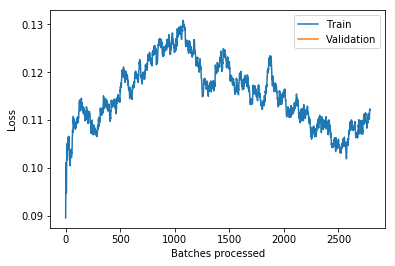

In [123]:
learn.recorder.plot_losses()

It's not easy to tell if a loss of 0.05 is any good or not. Seems our model is not doing a whole lot. Let's add the IoU metric to see where we are.

In [111]:
learn.validate()

[0.11069951, tensor(0.4489)]

In [19]:
learn.unfreeze()

In [20]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [21]:
learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.106759,0.096253,0.465358
2,0.105278,0.091785,0.478287
3,0.103389,0.089237,0.485769
4,0.100832,0.089303,0.486314
5,0.097904,0.082698,0.507163
6,0.096575,0.081890,0.496518
7,0.093673,0.078044,0.517173
8,0.090114,0.072488,0.537721
9,0.088702,0.087278,0.486347
10,0.086713,0.072012,0.539396


KeyboardInterrupt: 

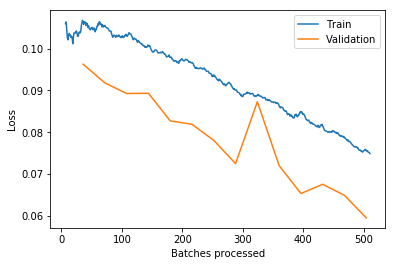

In [22]:
learn.recorder.plot_losses()

In [112]:
preds, targs = learn.get_preds()

Let's take a look at the results.

In [113]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()

In [114]:
def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


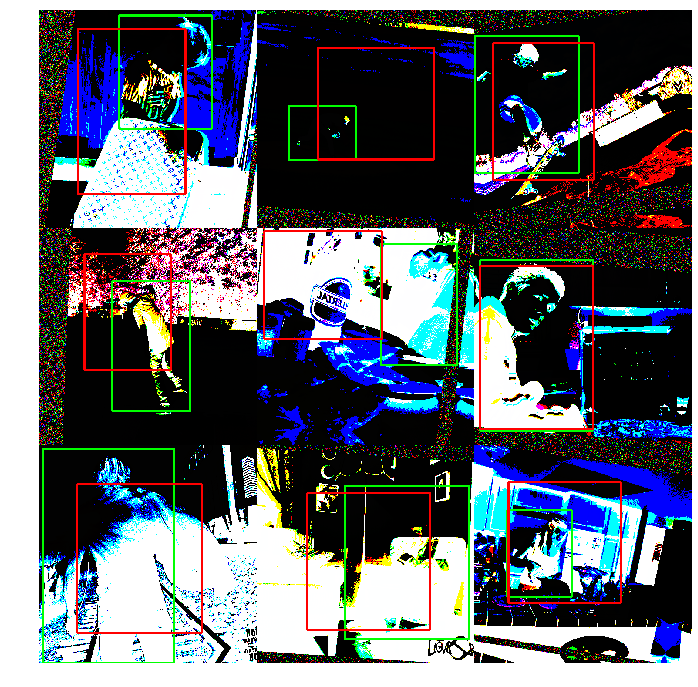

In [115]:
ims = np.stack([visualize(bbdata[i],target= predicted_bboxes[i]) for i in range(9,18)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [128]:
learn.save('fastai_bbox_detect_humans')

FileNotFoundError: [Errno 2] No such file or directory: 'models/saved_model/fastai_bbox_detect_humans.pth'